# Word Embeddings : le modèle Word2Vec

## Imports

In [14]:
import numpy as np
import pandas as pd
from pathlib import Path
import re
import nltk
import string

from nltk.corpus import stopwords
from nltk import word_tokenize

from gensim.models import Word2Vec
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to C:\Users\Ing Armel
[nltk_data]     Fopa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Ing Armel
[nltk_data]     Fopa\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to C:\Users\Ing Armel
[nltk_data]     Fopa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Liste des fichiers CAMille

In [15]:
from pathlib import Path

# Dossier contenant les fichiers CAMille
data_dir = Path("../../data/txt")

print("Dossier existe ? ", data_dir.exists())

all_txt = sorted(data_dir.glob("*.txt"))
print("Nombre total de fichiers texte :", len(all_txt))

# Aperçu des 10 premiers fichiers
for p in all_txt[:10]:
    print(" -", p.name)

Dossier existe ?  True
Nombre total de fichiers texte : 51
 - KB_JB230_1892-08-07_01-0003.txt
 - KB_JB230_1903-10-16_01-0002.txt
 - KB_JB230_1913-07-05_01-0001.txt
 - KB_JB258_1884-09-03_01-0003.txt
 - KB_JB258_1894-12-09_01-0003.txt
 - KB_JB258_1906-01-09_01-0002.txt
 - KB_JB421_1899-05-15_01-00003.txt
 - KB_JB421_1926-10-29_01-00002.txt
 - KB_JB421_1950-04-15_01-00004.txt
 - KB_JB427_1920-01-10_01-00004.txt


Selction des fichiers de la decennie 1920

In [16]:

# Sélection de la décennie
DECADE = "192"
pattern = re.compile(rf"{DECADE}\d")

# Fichiers correspondant à la décennie choisie
files_decade = [p for p in all_txt if pattern.search(p.name)]
print(f"Nombre de fichiers pour la décennie {DECADE}0 :", len(files_decade))
for p in files_decade:
    print(" -", p.name)

Nombre de fichiers pour la décennie 1920 : 7
 - KB_JB421_1926-10-29_01-00002.txt
 - KB_JB427_1920-01-10_01-00004.txt
 - KB_JB494_1922-09-28_01-0005.txt
 - KB_JB567_1924-08-30_01-00003.txt
 - KB_JB572_1927-07-20_01-00005.txt
 - KB_JB729_1927-11-15_01-00004.txt
 - KB_JB837_1925-01-01_01-00003.txt


### preparation et tokenisation du corpus

Preparation et nettoyage du texte

In [17]:
from nltk.corpus import stopwords
import string

# Stopwords français
sw = set(stopwords.words("french"))

def nettoyer_texte(texte):
    """Nettoyage léger : mise en minuscule, suppression des chiffres et ponctuation."""
    texte = texte.lower()
    texte = re.sub(r"\d+", " ", texte)                # supprime les chiffres
    texte = texte.translate(str.maketrans("", "", string.punctuation))  # supprime la ponctuation
    return texte

Tokenisation du corpus

In [18]:

from nltk.tokenize import word_tokenize

sentences = []

for path in files_decade:
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        txt = nettoyer_texte(f.read())
        tokens = [w for w in word_tokenize(txt) if w not in sw and len(w) > 2]
        sentences.append(tokens)

print(f"Nombre de documents préparés : {len(sentences)}")
print("Exemple de tokens :", sentences[0][:25])

Nombre de documents préparés : 7
Exemple de tokens : ['mariage', 'prince', 'léopold', 'départ', 'famille', 'royale', 'famille', 'royale', 'rendant', 'stockholm', 'assister', 'mariage', 'prince', 'léopold', 'princesse', 'princesse', 'astrid', 'lâge', 'huit', 'ans', 'astrid', 'quittera', 'bruxelles', 'samedi', 'scir']


Entrainement du modele avec Word2Vec

In [19]:
from gensim.models import Word2Vec

# Entraînement du modèle Word2Vec sur les phrases tokenisées
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=100,   # dimension des vecteurs de mots
    window=5,          # taille de la fenêtre de contexte
    min_count=2,       # ignore les mots apparaissant moins de 2 fois
    workers=4,         # nombre de threads (si dispo)
    sg=1               # 1 = skip-gram, 0 = CBOW
)

# Résumé du vocabulaire appris
print("Taille du vocabulaire :", len(w2v_model.wv.key_to_index))
print("Quelques mots appris :", list(w2v_model.wv.key_to_index.keys())[:20])

Taille du vocabulaire : 2923
Quelques mots appris : ['plus', 'rue', 'prix', 'congo', 'bruxelles', 'ord', 'tout', 'cette', 'heures', 'bien', 'deux', 'faire', 'anvers', 'quil', 'belge', 'cest', 'tous', 'comme', 'très', 'dem']


Test des similarites de mots

In [20]:
for mot in ["prince", "princesse", "mariage", "famille"]:
    if mot in w2v_model.wv:
        print(f"\nMots proches de « {mot} » :")
        for voisin, score in w2v_model.wv.most_similar(mot, topn=5):
            print(f"  {voisin:15s}  (similarité = {score:.3f})")
    else:
        print(f"\nLe mot « {mot} » n'est pas dans le vocabulaire.")


Mots proches de « prince » :
  rue              (similarité = 0.975)
  deux             (similarité = 0.975)
  place            (similarité = 0.974)
  plus             (similarité = 0.974)
  belge            (similarité = 0.974)

Mots proches de « princesse » :
  belgique         (similarité = 0.966)
  dun              (similarité = 0.960)
  deux             (similarité = 0.960)
  plus             (similarité = 0.959)
  rue              (similarité = 0.959)

Mots proches de « mariage » :
  quant            (similarité = 0.783)
  com­             (similarité = 0.782)
  galerie          (similarité = 0.782)
  pris             (similarité = 0.781)
  billets          (similarité = 0.780)

Mots proches de « famille » :
  belge            (similarité = 0.985)
  tout             (similarité = 0.985)
  dem              (similarité = 0.985)
  ans              (similarité = 0.984)
  rue              (similarité = 0.984)


Selection de queques mots pour projection

In [22]:
# Liste de mots qu'on aimerait visualiser
mots_interets = [
    "prince", "princesse", "mariage", "famille",
    "belge", "belgique", "rue", "prix", "congo", "ouvriers"
]

# Garder seulement ceux présents dans le vocabulaire
mots_plot = [m for m in mots_interets if m in w2v_model.wv]

print("Mots retenus pour la visualisation :")
print(mots_plot)

Mots retenus pour la visualisation :
['prince', 'princesse', 'mariage', 'famille', 'belge', 'belgique', 'rue', 'prix', 'congo', 'ouvriers']


PCA + visualisation 2D des vecteurs de mots

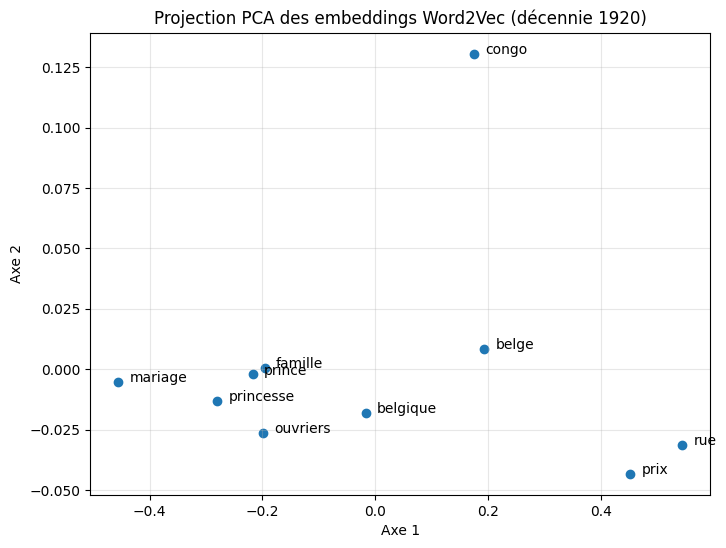

In [23]:
# Récupérer les vecteurs des mots sélectionnés
vectors = np.array([w2v_model.wv[m] for m in mots_plot])

# Réduction en 2D avec PCA
pca = PCA(n_components=2, random_state=0)
vec_2d = pca.fit_transform(vectors)

# Tracé
plt.figure(figsize=(8,6))
plt.scatter(vec_2d[:, 0], vec_2d[:, 1])

for (x, y), mot in zip(vec_2d, mots_plot):
    plt.text(x + 0.02, y, mot, fontsize=10)

plt.title("Projection PCA des embeddings Word2Vec (décennie 1920)")
plt.xlabel("Axe 1")
plt.ylabel("Axe 2")
plt.grid(alpha=0.3)
plt.show()